In [11]:
#imports
import datetime
import numpy as np
from pathlib import Path
import os
import time

import matplotlib
import matplotlib.pyplot as plt
    
from ocean_lib.example_config import ExampleConfig
from ocean_lib.ocean.ocean import Ocean
from ocean_lib.web3_internal.wallet import Wallet


#helper functions: setup
def create_ocean_instance() -> Ocean:
    config = ExampleConfig.get_config("https://polygon-rpc.com") # points to Polygon mainnet
    config["BLOCK_CONFIRMATIONS"] = 1 #faster
    ocean = Ocean(config)
    return ocean


def create_alice_wallet(ocean: Ocean) -> Wallet:
    config = ocean.config_dict
    alice_private_key = os.getenv('REMOTE_TEST_PRIVATE_KEY1')
    alice_wallet = Wallet(ocean.web3, alice_private_key, config["BLOCK_CONFIRMATIONS"], config["TRANSACTION_TIMEOUT"])
    bal = ocean.from_wei(alice_wallet.web3.eth.get_balance(alice_wallet.address))
    print(f"alice_wallet.address={alice_wallet.address}. bal={bal}")
    assert bal > 0, f"Alice needs MATIC"
    return alice_wallet


#helper functions: time
def to_unixtime(dt: datetime.datetime):
    return time.mktime(dt.timetuple())


def to_unixtimes(dts: list) -> list:
    return [to_unixtime(dt) for dt in dts]


def to_datetime(ut) -> datetime.datetime:
    return datetime.datetime.utcfromtimestamp(ut)


def to_datetimes(uts: list) -> list:
    return [to_datetime(ut) for ut in uts]


def round_to_nearest_hour(dt: datetime.datetime) -> datetime.datetime:
    return (dt.replace(second=0, microsecond=0, minute=0, hour=dt.hour)
            + datetime.timedelta(hours=dt.minute//30))


def pretty_time(dt: datetime.datetime) -> str:
    return dt.strftime('%Y/%m/%d, %H:%M:%S')


def print_datetime_info(descr:str, uts: list):
    dts = to_datetimes(uts)
    print(descr + ":")
    print(f"  starts on: {pretty_time(dts[0])}")
    print(f"    ends on: {pretty_time(dts[-1])}")
    print(f"  {len(dts)} datapoints")
    print(f"  time interval between datapoints: {(dts[1]-dts[0])}")


def target_12h_unixtimes(start_dt: datetime.datetime) -> list:
    target_dts = [start_dt + datetime.timedelta(hours=h) for h in range(12)]
    target_uts = to_unixtimes(target_dts)
    return target_uts


#helper-functions: higher level
def load_from_ohlc_data(file_name: str) -> tuple:
    """Returns (list_of_unixtimes, list_of_close_prices)"""
    with open(file_name, "r") as file:
        data_str = file.read().rstrip().replace('"', '')
    x = eval(data_str) #list of lists
    uts = [xi[0]/1000 for xi in x]
    #modified to return open high low close
    #vals = [xi[4] for xi in x]
    #return (uts, vals)
    o = [xi[1] for xi in x]
    h = [xi[2] for xi in x]
    l = [xi[3] for xi in x]
    c = [xi[4] for xi in x]
    
    return uts, o, h, l, c


def filter_to_target_uts(target_uts:list, unfiltered_uts:list, unfiltered_vals:list) -> list:
    """Return filtered_vals -- values at at the target timestamps"""
    filtered_vals = [None] * len(target_uts)
    for i, target_ut in enumerate(target_uts):
        time_diffs = np.abs(np.asarray(unfiltered_uts) - target_ut)
        tol_s = 1 #should always align within e.g. 1 second
        target_ut_s = pretty_time(to_datetime(target_ut))
        assert min(time_diffs) <= tol_s, \
            f"Unfiltered times is missing target time: {target_ut_s}"
        j = np.argmin(time_diffs)
        filtered_vals[i] = unfiltered_vals[j]
    return filtered_vals


#helpers: save/load list
def save_list(list_: list, file_name: str):
    """Save a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    p.write_text(str(list_))


def load_list(file_name: str) -> list:
    """Load from a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    s = p.read_text()
    list_ = eval(s)
    return list_


#helpers: prediction performance
def calc_nmse(y, yhat) -> float:
    assert len(y) == len(yhat)
    mse_xy = np.sum(np.square(np.asarray(y) - np.asarray(yhat)))
    mse_x = np.sum(np.square(np.asarray(y)))
    nmse = mse_xy / mse_x
    return nmse


def plot_prices(cex_vals, pred_vals):
    matplotlib.rcParams.update({'font.size': 22})
    
    x = [h for h in range(0,12)]
    assert len(x) == len(cex_vals) == len(pred_vals)
    
    fig, ax = plt.subplots()
    ax.plot(x, cex_vals, '--', label="CEX values")
    ax.plot(x, pred_vals, '-', label="Pred. values")
    ax.legend(loc='lower right')
    plt.ylabel("ETH price")
    plt.xlabel("Hour")
    fig.set_size_inches(18, 18)
    plt.xticks(x)
    plt.show()


In [5]:
os.environ['REMOTE_TEST_PRIVATE_KEY1'] = "c418c07d9291f16f8ae12b8121cff4207ea873c9f5dd0908ee6c2bdbd13de6b0"

In [7]:
ocean = create_ocean_instance()
alice_wallet = create_alice_wallet(ocean)

alice_wallet.address=0x19081dEd691eE3Cb1A45B19ae68Dd8d2A911b2e3. bal=4.830895846348421626


In [12]:
ETH_USDT_did = "did:op:0dac5eb4965fb2b485181671adbf3a23b0133abf71d2775eda8043e8efc92d19"
file_name = ocean.assets.download_file(ETH_USDT_did, alice_wallet)
allcex_uts, allcex_open, allcex_high, allcex_low, allcex_close = load_from_ohlc_data(file_name)
print_datetime_info("CEX data info", allcex_uts)

Resolve did...


Dispense access token...
Order access...


INFO:ocean_lib.data_provider.data_service_provider:Service initialized successfully initializeEndpoint https://v4.provider.polygon.oceanprotocol.com/api/services/initialize


Download file...


INFO:ocean_lib.data_provider.fileinfo_provider:Retrieved asset files successfully FileInfoEndpoint https://v4.provider.polygon.oceanprotocol.com/api/services/fileinfo from did did:op:0dac5eb4965fb2b485181671adbf3a23b0133abf71d2775eda8043e8efc92d19 with service id 8e2e09fd9b02e0b7e9c0d0e01c6f500e2a07aa305c04144ad96babf50b820c87


signing message with nonce 1667723230.494694: did:op:0dac5eb4965fb2b485181671adbf3a23b0133abf71d2775eda8043e8efc92d19, account=0x19081dEd691eE3Cb1A45B19ae68Dd8d2A911b2e3


INFO:ocean_lib.data_provider.base:Saved downloaded file in ./datafile.did:op:0dac5eb4965fb2b485181671adbf3a23b0133abf71d2775eda8043e8efc92d19,0/USDT.json
INFO:ocean_lib.data_provider.data_service_provider:Asset downloaded successfully downloadEndpoint https://v4.provider.polygon.oceanprotocol.com/api/services/download


Done. File: ./datafile.did:op:0dac5eb4965fb2b485181671adbf3a23b0133abf71d2775eda8043e8efc92d19,0/USDT.json
CEX data info:
  starts on: 2022/09/25, 12:00:00
    ends on: 2022/11/06, 03:00:00
  1000 datapoints
  time interval between datapoints: 1:00:00


In [13]:
import pandas as pd
dts = to_datetimes(allcex_uts)
df = pd.DataFrame({'ds':dts,'open':allcex_open, 'high':allcex_high, 'low':allcex_low,'close':allcex_close})


In [14]:
df.head()

,ds,open,high,low,close
0,2022-09-25 12:00:00,1329.33,1331.49,1322.22,1323.57
1,2022-09-25 13:00:00,1323.57,1323.84,1298.15,1306.11
2,2022-09-25 14:00:00,1306.11,1310.16,1299.21,1306.00
3,2022-09-25 15:00:00,1306.00,1314.53,1305.00,1310.79
4,2022-09-25 16:00:00,1310.78,1321.03,1301.50,1303.54


In [15]:
df.set_index('ds',inplace=True)

In [16]:
df.head()

,open,high,low,close
ds,,,,
2022-09-25 12:00:00,1329.33,1331.49,1322.22,1323.57
2022-09-25 13:00:00,1323.57,1323.84,1298.15,1306.11
2022-09-25 14:00:00,1306.11,1310.16,1299.21,1306.00
2022-09-25 15:00:00,1306.00,1314.53,1305.00,1310.79
2022-09-25 16:00:00,1310.78,1321.03,1301.50,1303.54


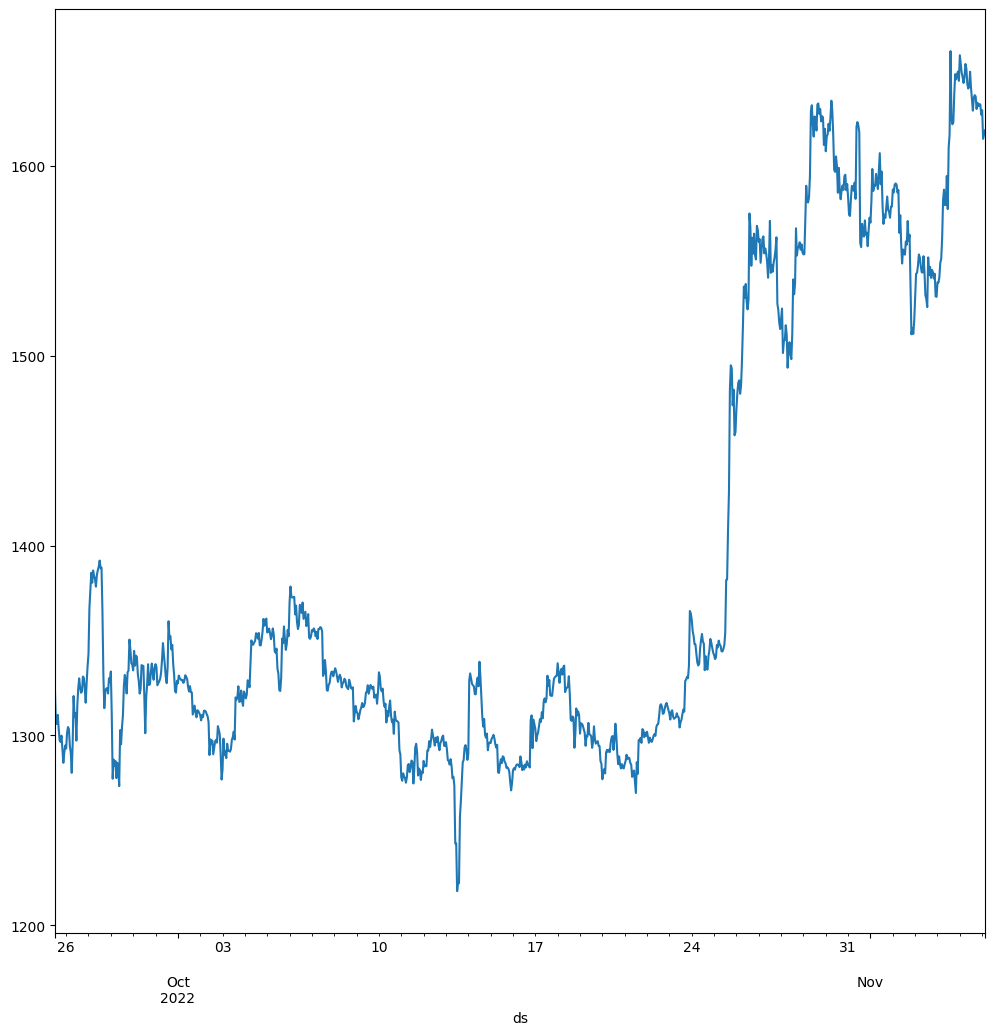

In [20]:
df['close'].plot(figsize=(12,12))
plt.show()

In [21]:
df.isna().sum()

open     0
high     0
low      0
close    0
dtype: int64

In [40]:
train = df.iloc[0:-60,:]
test = df.iloc[-60:,:]
print(len(train))
print(len(test))

940
60


In [78]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from scipy import stats

scaler = MinMaxScaler().fit(train)
y_scaler = MinMaxScaler().fit(train[['close']])
train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

In [100]:
def create_dataset (X, look_back = 1):
    Xs, ys = [], []
 
    for i in range(len(X)-look_back):
        v = X[i:i+look_back, :-1]
        print(v)
        Xs.append(v)
        ys.append([X[i-look_back:i][-1]])
 
    return np.array(Xs), np.array(ys)

LOOK_BACK = 48

X_train, y_train = create_dataset(train_scaled,LOOK_BACK)
X_test, y_test = create_dataset(test_scaled,LOOK_BACK)
print("X_train.shape: ", X_train.shape)
print("y_train.shape: ", y_train.shape)
print("X_test.shape: ", X_test.shape) 
print("y_test.shape: ", y_test.shape)

[[0.26753122 0.23971016 0.30250063]
 [0.25369837 0.22216872 0.24743188]
 [0.21176753 0.19080049 0.24985701]
 [0.21150336 0.20082089 0.26310371]
 [0.22298271 0.21572539 0.2550962 ]
 [0.20559558 0.17756988 0.21027706]
 [0.1907781  0.16899406 0.22727585]
 [0.18868876 0.17580427 0.23905832]
 [0.19663785 0.16789342 0.23123384]
 [0.17869837 0.15489211 0.20629619]
 [0.16236792 0.17461191 0.18135853]
 [0.17533622 0.16816858 0.2248736 ]
 [0.18417387 0.19414827 0.22883159]
 [0.18040346 0.18387563 0.22164772]
 [0.20040826 0.1877508  0.24978837]
 [0.20758886 0.20086675 0.25431833]
 [0.20487512 0.18206416 0.23738818]
 [0.18347743 0.15920295 0.22025212]
 [0.17473583 0.1590883  0.20098835]
 [0.14961575 0.16855839 0.20442014]
 [0.18611912 0.21964642 0.23651879]
 [0.24680596 0.22496618 0.2700588 ]
 [0.22043708 0.2087776  0.26767943]
 [0.22519212 0.19903235 0.22723009]
 [0.19041787 0.2177203  0.23725091]
 [0.23518252 0.22998785 0.27117985]
 [0.25665226 0.25580702 0.29922899]
 [0.26914025 0.24120061 0.28

[[0.23804035 0.20836486 0.28550184]
 [0.23285303 0.208319   0.28241323]
 [0.23388569 0.20864002 0.28561623]
 [0.23837656 0.22858912 0.28769819]
 [0.25076849 0.23168467 0.30279805]
 [0.25256964 0.2340006  0.30446819]
 [0.2604707  0.23145537 0.30128806]
 [0.24966378 0.22700695 0.29964081]
 [0.2554755  0.22994199 0.30586378]
 [0.2607829  0.23097384 0.30176851]
 [0.25814121 0.2273509  0.30446819]
 [0.2559318  0.22792415 0.30227184]
 [0.25869356 0.2280388  0.274543  ]
 [0.24466859 0.21574832 0.29046649]
 [0.24731028 0.2213891  0.29241117]
 [0.24858309 0.21698654 0.28836166]
 [0.23710375 0.22122859 0.28449518]
 [0.25264169 0.2460847  0.29808506]
 [0.27677714 0.25463759 0.32126107]
 [0.27132565 0.23847195 0.30346153]
 [0.2557877  0.22709867 0.29970944]
 [0.25276177 0.22572287 0.30151685]
 [0.25626801 0.2248286  0.2884303 ]
 [0.24020173 0.2142808  0.27948477]
 [0.23330932 0.21311137 0.28390034]
 [0.23719981 0.20795212 0.24333661]
 [0.21342459 0.19735846 0.26383582]
 [0.22800192 0.20132535 0.27

[[0.16068684 0.13932265 0.21176417]
 [0.16486551 0.14801312 0.21945137]
 [0.17257445 0.15030612 0.22153332]
 [0.16714697 0.14537617 0.21723215]
 [0.16897214 0.14503222 0.22137317]
 [0.16834774 0.14698127 0.21686609]
 [0.16212776 0.14521566 0.2119472 ]
 [0.16011047 0.13310862 0.19243176]
 [0.14454851 0.12661943 0.18927452]
 [0.15       0.12579395 0.20023336]
 [0.15264169 0.12506019 0.19426205]
 [0.13832853 0.11196716 0.14333432]
 [0.12408742 0.13583729 0.17902491]
 [0.16316042 0.14569719 0.19558901]
 [0.14824688 0.16271124 0.1993411 ]
 [0.19099424 0.17449726 0.24139193]
 [0.18979347 0.17630873 0.23985907]
 [0.19382805 0.17575841 0.24045391]
 [0.18760807 0.18048199 0.2408886 ]
 [0.2049952  0.18348582 0.25308289]
 [0.20348223 0.17426796 0.24537281]
 [0.19476465 0.17082846 0.24782081]
 [0.20048031 0.17174566 0.24827839]
 [0.19651777 0.17477242 0.24818687]
 [0.20163305 0.17823485 0.24862157]
 [0.19464457 0.16938387 0.2396074 ]
 [0.18768012 0.16560042 0.23866938]
 [0.19426033 0.16809979 0.24

[[0.78114793 0.72617    0.76439635]
 [0.75235351 0.70413428 0.76732481]
 [0.7518732  0.71915342 0.77421126]
 [0.77012488 0.72610121 0.79253701]
 [0.76978866 0.72841714 0.79535107]
 [0.776561   0.74050125 0.79608319]
 [0.79490874 0.74412419 0.81569013]
 [0.79990394 0.77808351 0.81889313]
 [0.82620077 0.82832313 0.84046764]
 [0.87475985 0.82740593 0.87929259]
 [0.88736792 0.82862122 0.88864993]
 [0.86793948 0.82169636 0.88670526]
 [0.86839577 0.85604549 0.88151182]
 [0.90475504 0.84338814 0.8847377 ]
 [0.86289625 0.8811997  0.83781372]
 [0.94089817 0.91100869 0.95232103]
 [0.95706052 1.03884341 0.96970876]
 [1.06272815 1.00084841 0.99142053]
 [0.97752161 0.92449153 0.95586721]
 [0.97017291 0.92031827 0.96893088]
 [0.97238232 0.96496297 0.97787641]
 [1.00763689 0.96968655 1.01704454]
 [1.03350144 0.9700305  1.02917019]
 [1.02694524 0.97365344 1.02971928]
 [1.03369356 0.98099103 1.03850466]
 [1.03683958 0.97610695 1.03415772]
 [1.02509606 1.00896563 1.01844014]
 [1.05751681 0.99158469 1.04

In [130]:
# Create BiLSTM model
def create_bilstm(units):
    model = Sequential()
    # Input layer
    model.add(Bidirectional(
              LSTM(units = units, return_sequences=True), 
              input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    # Hidden layer
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    #Compile model
    model.compile(optimizer="adam",loss="mse")
    return model

def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = "val_loss",
                                               patience = 10)
    history = model.fit(X_train, y_train, epochs = 100,  
                        validation_split = 0.2,
                        batch_size = 16, shuffle = False, 
                        callbacks = [early_stop], 
                        verbose=2)
    return history

In [102]:
model_bilstm = create_bilstm(250)
history_bilstm = fit_model(model_bilstm)

Epoch 1/100
45/45 - 16s - loss: 0.0063 - val_loss: 0.0520 - 16s/epoch - 365ms/step
Epoch 2/100
45/45 - 12s - loss: 0.0068 - val_loss: 0.1027 - 12s/epoch - 274ms/step
Epoch 3/100
45/45 - 12s - loss: 0.0087 - val_loss: 0.0387 - 12s/epoch - 263ms/step
Epoch 4/100
45/45 - 10s - loss: 0.0061 - val_loss: 0.0063 - 10s/epoch - 227ms/step
Epoch 5/100
45/45 - 10s - loss: 0.0031 - val_loss: 0.0015 - 10s/epoch - 225ms/step
Epoch 6/100
45/45 - 10s - loss: 0.0015 - val_loss: 0.0031 - 10s/epoch - 227ms/step
Epoch 7/100
45/45 - 10s - loss: 0.0021 - val_loss: 0.0019 - 10s/epoch - 225ms/step
Epoch 8/100
45/45 - 10s - loss: 0.0015 - val_loss: 0.0019 - 10s/epoch - 225ms/step
Epoch 9/100
45/45 - 11s - loss: 0.0024 - val_loss: 0.0023 - 11s/epoch - 239ms/step
Epoch 10/100
45/45 - 11s - loss: 0.0010 - val_loss: 0.0026 - 11s/epoch - 246ms/step
Epoch 11/100
45/45 - 10s - loss: 0.0013 - val_loss: 0.0024 - 10s/epoch - 225ms/step
Epoch 12/100
45/45 - 10s - loss: 0.0016 - val_loss: 0.0045 - 10s/epoch - 226ms/step
E

Epoch 98/100
45/45 - 13s - loss: 0.0015 - val_loss: 0.0026 - 13s/epoch - 279ms/step
Epoch 99/100
45/45 - 12s - loss: 0.0014 - val_loss: 0.0012 - 12s/epoch - 262ms/step
Epoch 100/100
45/45 - 11s - loss: 0.0016 - val_loss: 0.0025 - 11s/epoch - 255ms/step


In [103]:
y_test = y_scaler.inverse_transform(y_test)
y_train = y_scaler.inverse_transform(y_train)

In [104]:
def prediction(model):
    prediction = model.predict(X_test)
    prediction = y_scaler.inverse_transform(prediction)
    return prediction
prediction_bilstm = prediction(model_bilstm)

1/1 [==============================] - 1s 1s/step


In [105]:
nmse = calc_nmse(y_test, prediction_bilstm)
print(f"NMSE = {nmse}")

NMSE = 0.00017660001659846033


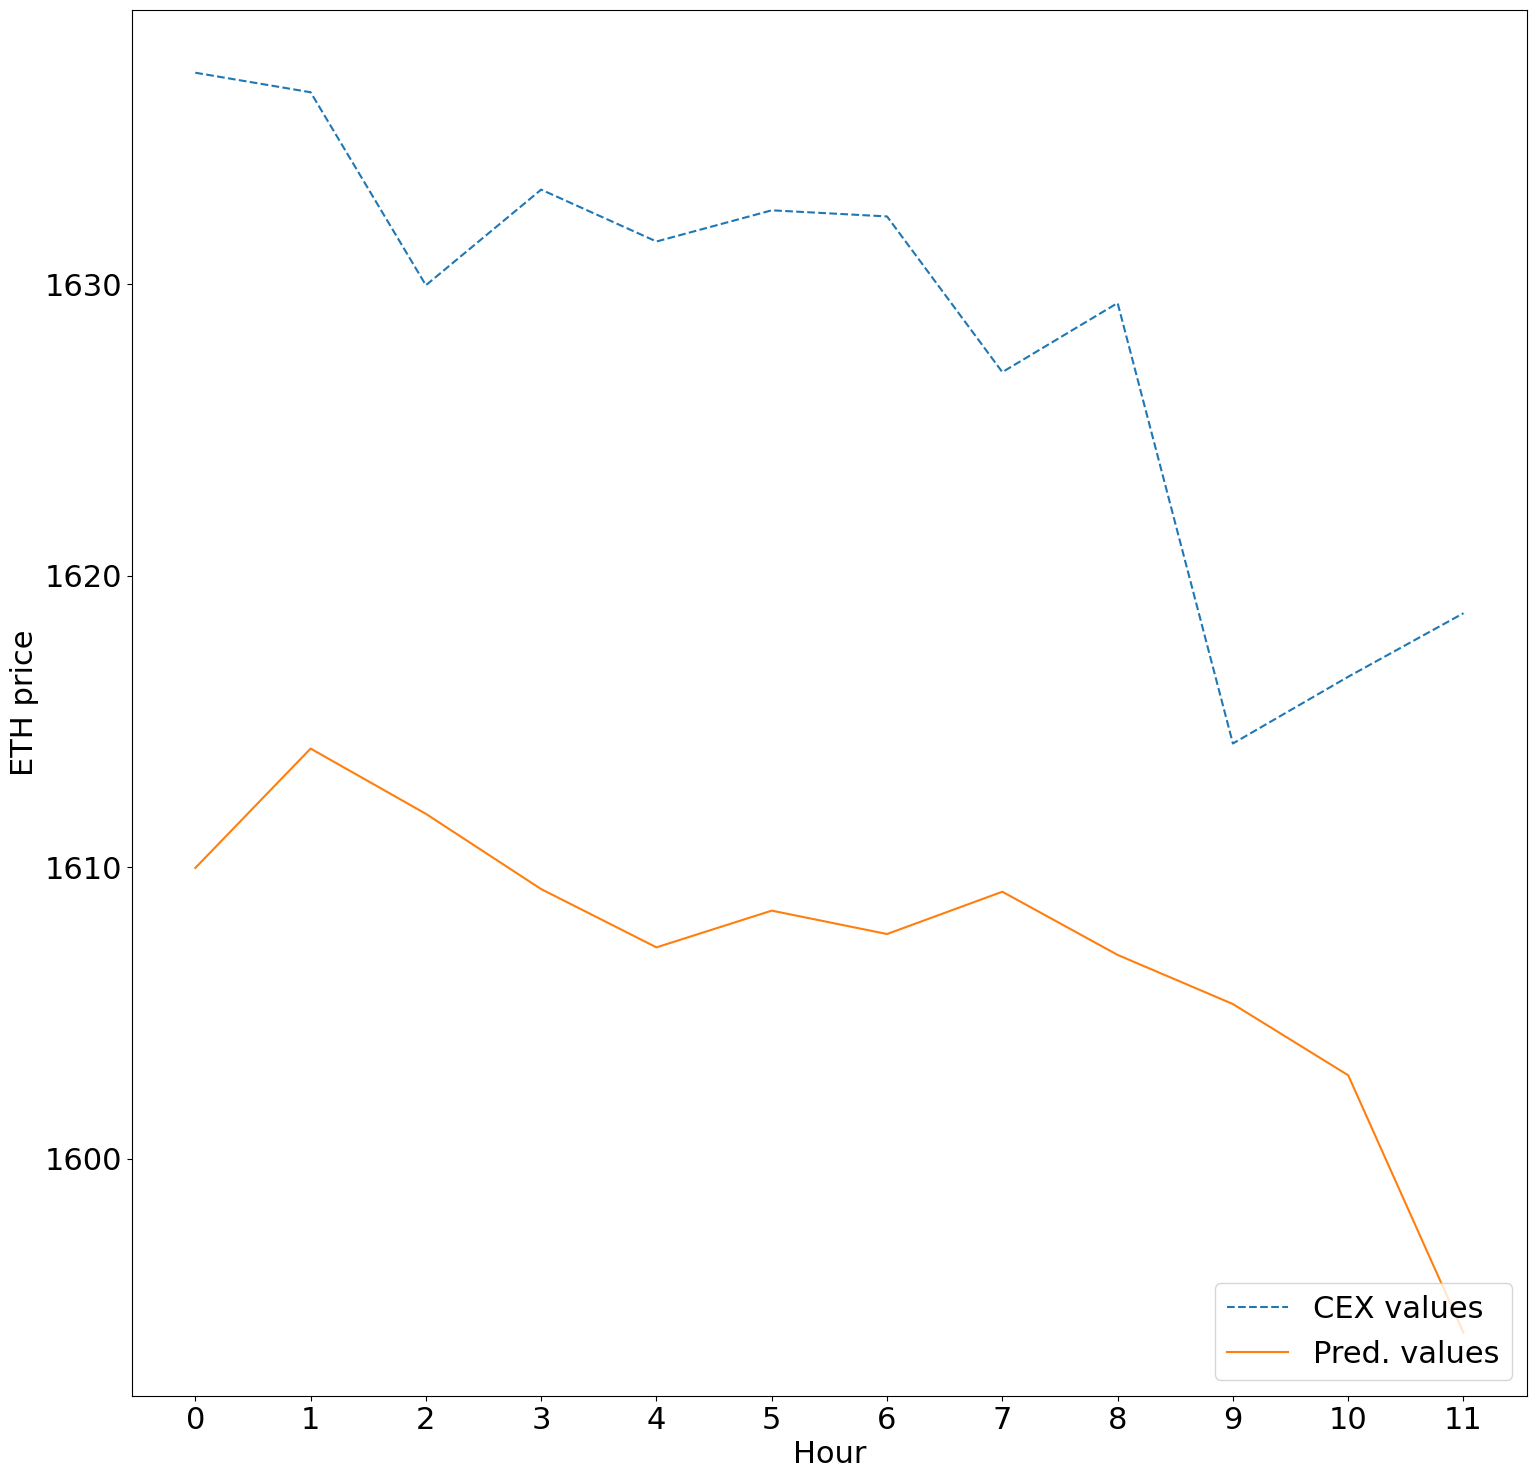

In [106]:
plot_prices(y_test, prediction_bilstm)

In [107]:
df.head()

,open,high,low,close
ds,,,,
2022-09-25 12:00:00,1329.33,1331.49,1322.22,1323.57
2022-09-25 13:00:00,1323.57,1323.84,1298.15,1306.11
2022-09-25 14:00:00,1306.11,1310.16,1299.21,1306.00
2022-09-25 15:00:00,1306.00,1314.53,1305.00,1310.79
2022-09-25 16:00:00,1310.78,1321.03,1301.50,1303.54


In [108]:
df['open_close_pct_change'] = (df['open'] - df['close']/df['open'])
df['high_low_pct_change'] = (df['high'] - df['low']/df['high'])
df['close_diff'] = df['close'].diff()
df['close_diff_rolling'] = df['close_diff'].rolling(3).mean()

In [109]:
df.head                                                                                                                                                                                                                                                                                                                                              

,open,high,low,close,open_close_pct_change,high_low_pct_change,close_diff,close_diff_rolling
ds,,,,,,,,
2022-09-25 12:00:00,1329.33,1331.49,1322.22,1323.57,1328.334333,1330.496962,NaN,NaN
2022-09-25 13:00:00,1323.57,1323.84,1298.15,1306.11,1322.583192,1322.859406,-17.46,NaN
2022-09-25 14:00:00,1306.11,1310.16,1299.21,1306.00,1305.110084,1309.168358,-0.11,NaN
2022-09-25 15:00:00,1306.00,1314.53,1305.00,1310.79,1304.996332,1313.537250,4.79,-4.260000
2022-09-25 16:00:00,1310.78,1321.03,1301.50,1303.54,1309.785523,1320.044784,-7.25,-0.856667


In [110]:
df = df[['open','high','low', 'open_close_pct_change', 'high_low_pct_change', 'close_diff', 'close_diff_rolling', 'close']]
df.head()

,open,high,low,open_close_pct_change,high_low_pct_change,close_diff,close_diff_rolling,close
ds,,,,,,,,
2022-09-25 12:00:00,1329.33,1331.49,1322.22,1328.334333,1330.496962,NaN,NaN,1323.57
2022-09-25 13:00:00,1323.57,1323.84,1298.15,1322.583192,1322.859406,-17.46,NaN,1306.11
2022-09-25 14:00:00,1306.11,1310.16,1299.21,1305.110084,1309.168358,-0.11,NaN,1306.00
2022-09-25 15:00:00,1306.00,1314.53,1305.00,1304.996332,1313.537250,4.79,-4.260000,1310.79
2022-09-25 16:00:00,1310.78,1321.03,1301.50,1309.785523,1320.044784,-7.25,-0.856667,1303.54


In [111]:
train = df.iloc[0:-60,:].dropna()
test = df.iloc[-60:,:].dropna()
print(len(train))
print(len(test))

937
60


In [117]:
scaler = MinMaxScaler().fit(train)
y_scaler = MinMaxScaler().fit(train[['close']])
train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)
train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)
def create_dataset (X, look_back = 1):
    Xs, ys = [], []
 
    for i in range(len(X)-look_back):
        v = X[i:i+look_back, :-1]
        Xs.append(v)
        ys.append([X[i+look_back][-1]])
 
    return np.array(Xs), np.array(ys)
X_train, y_train = create_dataset(train_scaled,LOOK_BACK)
X_test, y_test = create_dataset(test_scaled,LOOK_BACK)
print("X_train.shape: ", X_train.shape)
print("y_train.shape: ", y_train.shape)
print("X_test.shape: ", X_test.shape) 
print("y_test.shape: ", y_test.shape)

X_train.shape:  (889, 48, 7)
y_train.shape:  (889, 1)
X_test.shape:  (12, 48, 7)
y_test.shape:  (12, 1)


In [119]:
model_bilstm2 = create_bilstm(250)
history_bilstm2 = fit_model(model_bilstm2)

Epoch 1/100
45/45 - 20s - loss: 0.0150 - val_loss: 0.0958 - 20s/epoch - 433ms/step
Epoch 2/100
45/45 - 11s - loss: 0.0124 - val_loss: 0.0039 - 11s/epoch - 242ms/step
Epoch 3/100
45/45 - 11s - loss: 0.0059 - val_loss: 0.0041 - 11s/epoch - 241ms/step
Epoch 4/100
45/45 - 11s - loss: 0.0042 - val_loss: 0.0021 - 11s/epoch - 240ms/step
Epoch 5/100
45/45 - 11s - loss: 0.0057 - val_loss: 0.0118 - 11s/epoch - 240ms/step
Epoch 6/100
45/45 - 11s - loss: 0.0050 - val_loss: 0.0106 - 11s/epoch - 239ms/step
Epoch 7/100
45/45 - 11s - loss: 0.0054 - val_loss: 0.0125 - 11s/epoch - 248ms/step
Epoch 8/100
45/45 - 11s - loss: 0.0035 - val_loss: 0.0057 - 11s/epoch - 244ms/step
Epoch 9/100
45/45 - 12s - loss: 0.0049 - val_loss: 0.0042 - 12s/epoch - 266ms/step
Epoch 10/100
45/45 - 12s - loss: 0.0044 - val_loss: 0.0152 - 12s/epoch - 271ms/step
Epoch 11/100
45/45 - 11s - loss: 0.0044 - val_loss: 0.0023 - 11s/epoch - 242ms/step
Epoch 12/100
45/45 - 11s - loss: 0.0025 - val_loss: 0.0054 - 11s/epoch - 242ms/step
E

Epoch 97/100
45/45 - 10s - loss: 5.4933e-04 - val_loss: 0.0015 - 10s/epoch - 227ms/step
Epoch 98/100
45/45 - 10s - loss: 6.5290e-04 - val_loss: 0.0016 - 10s/epoch - 226ms/step
Epoch 99/100
45/45 - 10s - loss: 6.5929e-04 - val_loss: 9.0220e-04 - 10s/epoch - 226ms/step
Epoch 100/100
45/45 - 10s - loss: 5.7455e-04 - val_loss: 9.5606e-04 - 10s/epoch - 227ms/step


In [120]:
prediction_bilstm2 = prediction(model_bilstm2)

1/1 [==============================] - 1s 1s/step


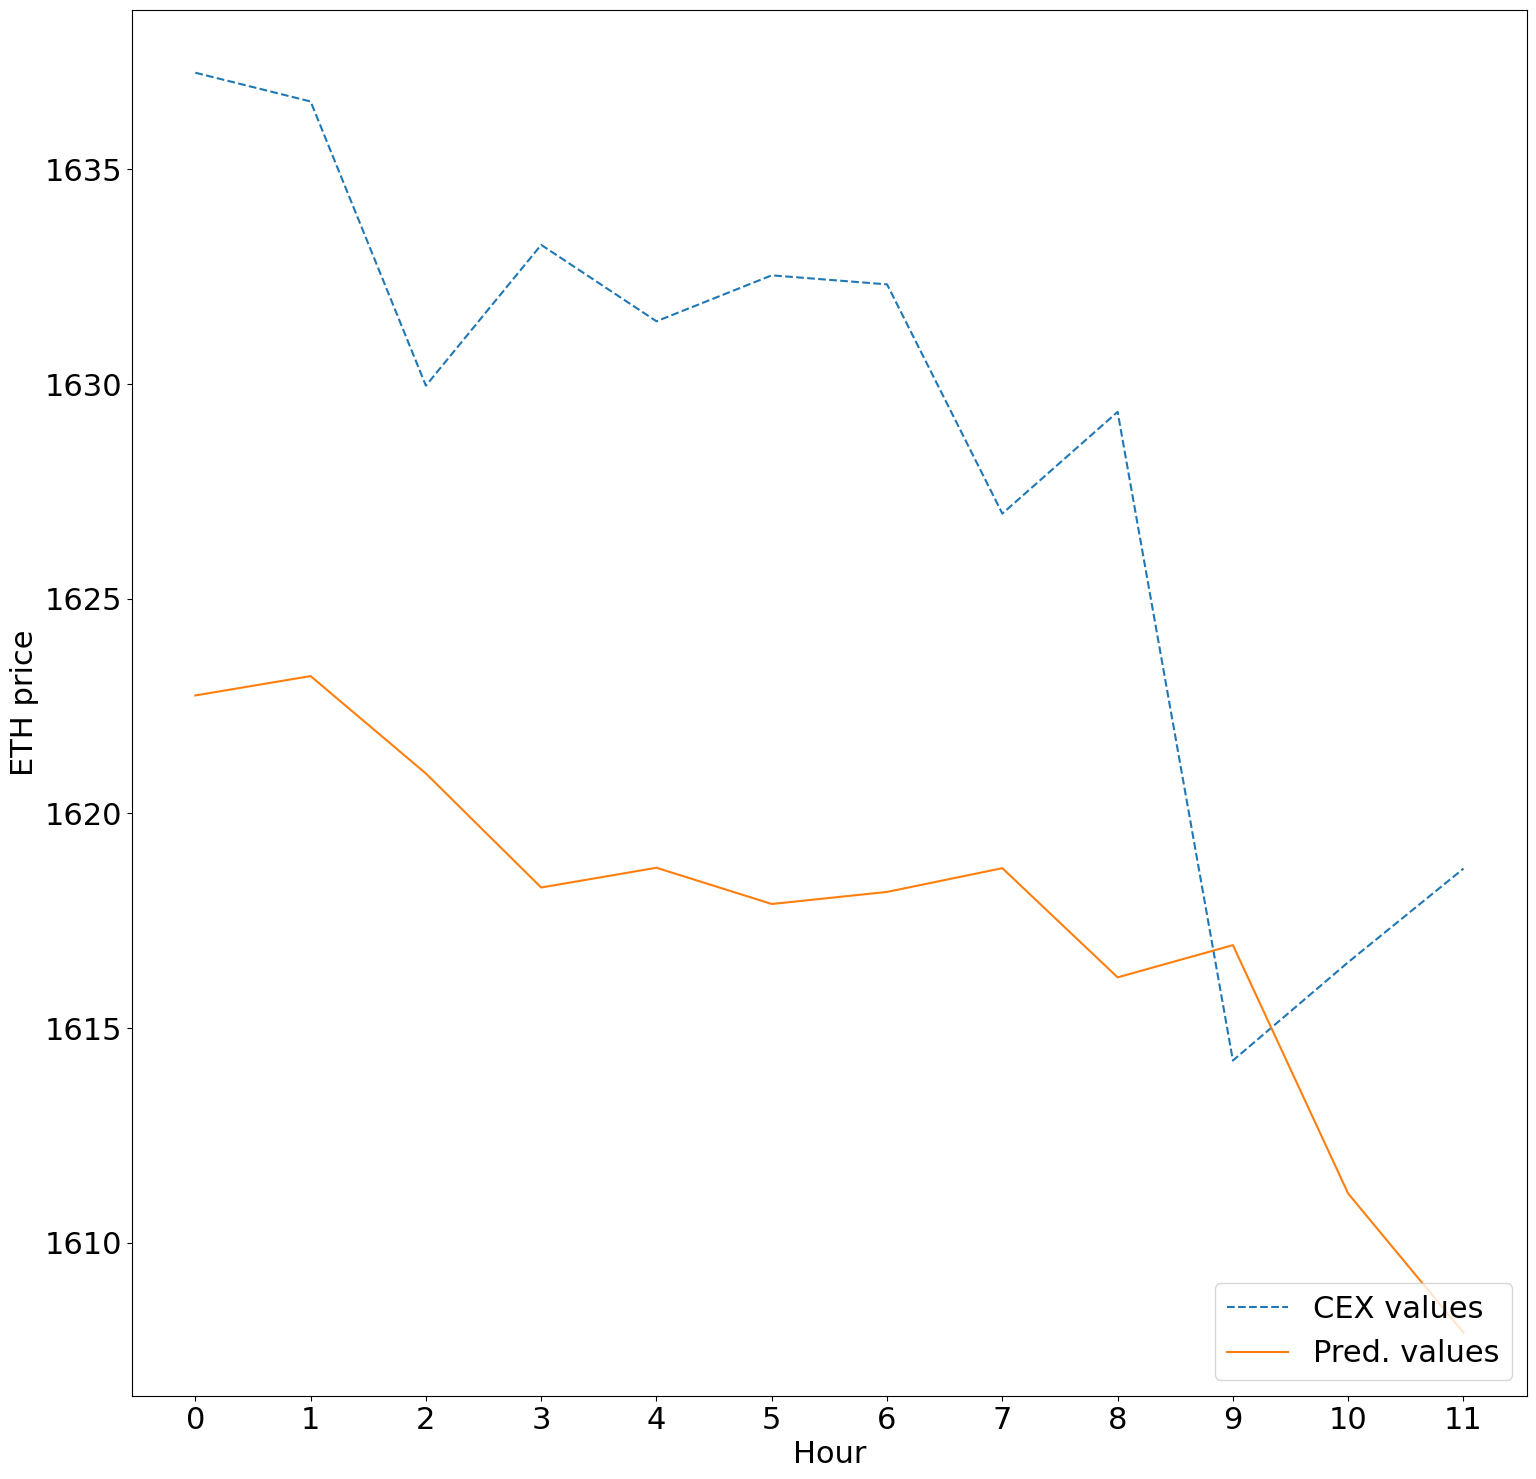

In [123]:
y_test = y_scaler.inverse_transform(y_test)
y_train = y_scaler.inverse_transform(y_train)
plot_prices(y_test, prediction_bilstm2)

In [124]:
nmse = calc_nmse(y_test, prediction_bilstm2)
print(f"NMSE = {nmse}")

NMSE = 5.239739278852979e-05


In [129]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, prediction_bilstm2)
print(f"R2 = {r2}")

R2 = -1.5612579036348415


In [133]:
#run with early stopping
scaler = MinMaxScaler().fit(train)
y_scaler = MinMaxScaler().fit(train[['close']])
train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)
train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)
def create_dataset (X, look_back = 1):
    Xs, ys = [], []
 
    for i in range(len(X)-look_back):
        v = X[i:i+look_back, :-1]
        Xs.append(v)
        ys.append([X[i+look_back][-1]])
 
    return np.array(Xs), np.array(ys)
X_train, y_train = create_dataset(train_scaled,LOOK_BACK)
X_test, y_test = create_dataset(test_scaled,LOOK_BACK)
print("X_train.shape: ", X_train.shape)
print("y_train.shape: ", y_train.shape)
print("X_test.shape: ", X_test.shape) 
print("y_test.shape: ", y_test.shape)
model_bilstm3 = create_bilstm(250)
history_bilstm3 = fit_model(model_bilstm3)

X_train.shape:  (889, 48, 7)
y_train.shape:  (889, 1)
X_test.shape:  (12, 48, 7)
y_test.shape:  (12, 1)
Epoch 1/100
45/45 - 14s - loss: 0.0188 - val_loss: 0.1796 - 14s/epoch - 306ms/step
Epoch 2/100
45/45 - 11s - loss: 0.0147 - val_loss: 0.0068 - 11s/epoch - 240ms/step
Epoch 3/100
45/45 - 10s - loss: 0.0063 - val_loss: 0.0041 - 10s/epoch - 233ms/step
Epoch 4/100
45/45 - 11s - loss: 0.0066 - val_loss: 0.0143 - 11s/epoch - 239ms/step
Epoch 5/100
45/45 - 10s - loss: 0.0064 - val_loss: 0.0026 - 10s/epoch - 229ms/step
Epoch 6/100
45/45 - 10s - loss: 0.0033 - val_loss: 0.0032 - 10s/epoch - 229ms/step
Epoch 7/100
45/45 - 11s - loss: 0.0041 - val_loss: 0.0022 - 11s/epoch - 244ms/step
Epoch 8/100
45/45 - 10s - loss: 0.0031 - val_loss: 0.0039 - 10s/epoch - 230ms/step
Epoch 9/100
45/45 - 10s - loss: 0.0038 - val_loss: 0.0022 - 10s/epoch - 229ms/step
Epoch 10/100
45/45 - 10s - loss: 0.0023 - val_loss: 0.0018 - 10s/epoch - 229ms/step
Epoch 11/100
45/45 - 10s - loss: 0.0028 - val_loss: 0.0019 - 10s/

In [134]:
prediction_bilstm3 = prediction(model_bilstm3)

1/1 [==============================] - 1s 1s/step


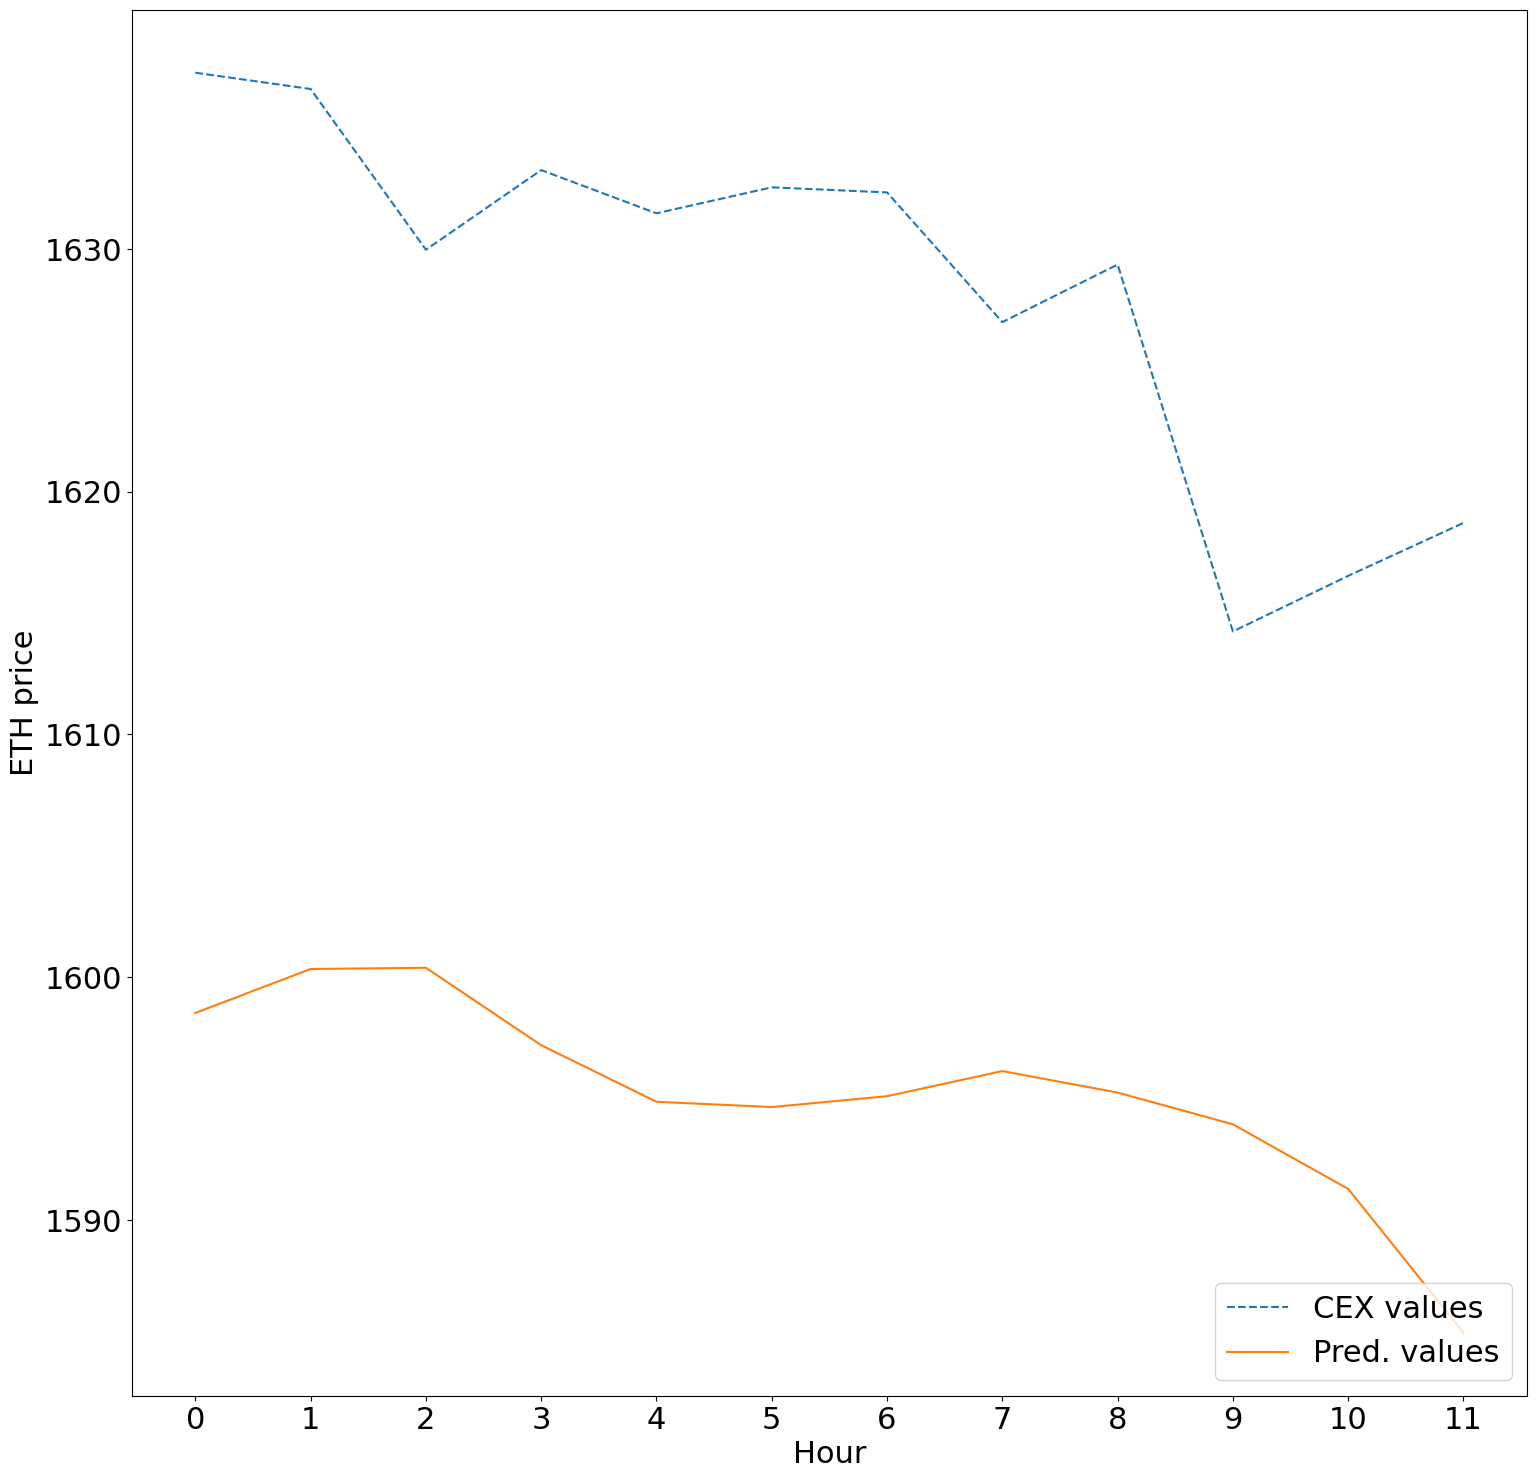

In [139]:
scaler = MinMaxScaler().fit(train)
y_scaler = MinMaxScaler().fit(train[['close']])
train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)
train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)
def create_dataset (X, look_back = 1):
    Xs, ys = [], []
 
    for i in range(len(X)-look_back):
        v = X[i:i+look_back, :-1]
        Xs.append(v)
        ys.append([X[i+look_back][-1]])
 
    return np.array(Xs), np.array(ys)
X_train, y_train = create_dataset(train_scaled,LOOK_BACK)
X_test, y_test = create_dataset(test_scaled,LOOK_BACK)
y_test = y_scaler.inverse_transform(y_test)
y_train = y_scaler.inverse_transform(y_train)
plot_prices(y_test, prediction_bilstm3)

In [141]:
nmse = calc_nmse(y_test, prediction_bilstm3)
print(f"NMSE = {nmse}")

NMSE = 0.00042183648598182323


In [143]:
import pickle as pkl
with open('model_bilstm_no_stop_feature_engineered.pkl', 'wb') as f:
    
    pkl.dump(model_bilstm3,f)

INFO:tensorflow:Assets written to: ram://dfec5ead-fc0f-49e0-9ae7-c639233088a1/assets
